# Multi-modal RAG


## Overview

Many documents contain a mixture of content types, including text, tables, and images. 

Semi-structured data can be challenging for [conventional RAG](https://github.com/TCLee/rag-langchain) for at least two reasons:

* Text splitting may break up tables, corrupting the data in retrieval.
* Embedding tables may pose challenges for semantic similarity search.

And the information captured in images is typically lost.

With the emergence of more affordable multimodal LLMs, like [Gemini 1.5 Flash](https://ai.google.dev/gemini-api/docs/models/gemini#gemini-1.5-flash) and [GPT-4o mini](https://platform.openai.com/docs/models/gpt-4o-mini), it is worth considering how to utilize images in RAG.

In this notebook, we will:
* Use a multimodal LLM such as [Gemini 1.5 Flash](https://ai.google.dev/gemini-api/docs/models/gemini#gemini-1.5-flash) to produce text summaries from images.
* Embed and retrieve image summaries with a reference to the raw image.
* Pass raw images and text chunks to a multimodal LLM for answer synthesis. 

Read the 
[LangChain blog post](https://blog.langchain.dev/semi-structured-multi-modal-rag/) 
to see other options for handling images in your documents.

More specifically, we will:
* Use [Unstructured](https://docs.unstructured.io) to parse images, text, and tables from PDF document.
* Use LangChain's [Multi-Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) to store raw text, tables and images along with their summaries for retrieval.
* Use [Gemini 1.5 Flash](https://ai.google.dev/gemini-api/docs/models/gemini#gemini-1.5-flash) for both image summarization (for retrieval) as well as final answer synthesis from join review of images and texts (or tables).

![Multi-modal RAG: Different strategies for dealing with images](img/multi_modal_options.png)

> **Figure 1**: Image from [LangChain](https://blog.langchain.dev/semi-structured-multi-modal-rag/#multi-vector-retriever). Shows the 3 different strategies for dealing with images in documents. We will be using `Option 3` in this notebook.

<br />

The code in this notebook is adapted from the 
[LangChain cookbook](https://github.com/langchain-ai/langchain/blob/master/cookbook/Multi_modal_RAG.ipynb).

## Setup

Before we begin, please make sure you have setup the `.env` file in the project 
directory as described in [`README.md`](README.md).

Next, we will load in the necessary environment variables (e.g., API keys) for this notebook:

In [ ]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload all

In [3]:
import os
from dotenv import load_dotenv

_ = load_dotenv()

assert os.environ.get("GOOGLE_API_KEY")

## Data Ingestion

We will use [Unstructured](https://docs.unstructured.io/open-source/introduction/overview) to partition and chunk a PDF document that includes texts, tables and images.

The PDF document we will be using is a [subset](data/input-docs/LLaVA-subset.pdf) (9 pages) of the original [LLaVA paper](https://arxiv.org/pdf/2304.08485.pdf) (25 pages). `LLaVA` is an open source multi-modal LLM that can also be used for multi-modal RAG in place of `Gemini 1.5 Flash`.

We will create a data ingestion pipeline to load, partition and chunk the PDF document.

In [4]:
from unstructured.ingest.v2.pipeline.pipeline import Pipeline
from unstructured.ingest.v2.interfaces import ProcessorConfig
from unstructured.ingest.v2.processes.connectors.local import (
    LocalIndexerConfig,
    LocalDownloaderConfig,
    LocalConnectionConfig,
    LocalUploaderConfig
)
from unstructured.ingest.v2.processes.partitioner import PartitionerConfig
from unstructured.ingest.v2.processes.chunker import ChunkerConfig


def create_data_ingestion_pipeline(
    input_pdf_path: str,
    output_dir: str,
    image_output_dir: str,
) -> Pipeline:
    """
    Creates a data ingestion pipeline. 
    
    The data ingestion pipeline runs the 
    following tasks:
    1. Loads in a PDF document.
    2. Partitions the PDF using Unstructured's `hi_res` 
       strategy into elements (text, tables, images).
    3. Chunks the PDF by title.
    4. Writes the partitioned and chunked elements 
       to a JSON file.

    Args:
        input_pdf_path: Path to the PDF document.
        output_dir: Path to directory to write the results 
            JSON file to.
        image_output_dir: Path to directory to save the 
            extracted images to.

    Returns:
        A data ingestion pipeline that can be run.
    """
    return Pipeline.from_configs(
        context=ProcessorConfig(
            verbose=True,
            tqdm=True,
        ),
        indexer_config=LocalIndexerConfig(
            input_path=input_pdf_path,
        ),
        downloader_config=LocalDownloaderConfig(),
        source_connection_config=LocalConnectionConfig(),
        partitioner_config=PartitionerConfig(
            partition_by_api=False,
            strategy="hi_res",        
            additional_partition_args={
                "languages": ["eng"],            
                "extract_images_in_pdf": True,
                "extract_image_block_types": ["Image", "Table"],
                "extract_image_block_output_dir": image_output_dir,
            }
        ),
        chunker_config=ChunkerConfig(
            chunking_strategy="by_title",
            # Chunking params to aggregate text blocks
            # Attempt to create a new chunk 3800 chars
            # Attempt to keep chunks > 2000 chars
            chunk_max_characters=4000,
            chunk_new_after_n_chars=3800,
            chunk_combine_text_under_n_chars=2000
        ),
        uploader_config=LocalUploaderConfig(
            output_dir=output_dir,
        ),
    )

Parsing and extracting a complex PDF document with tables and images will take some time. This process will run on your local machine.

In [5]:
# Set to `True` if you want to re-run the partition and chunking step.
# Leave it as `False` to re-use existing results.
RUN_PARTITION_CHUNKING_STEP = False

if RUN_PARTITION_CHUNKING_STEP:
    ingest_pipeline = create_data_ingestion_pipeline(
        input_pdf_path="data/input-docs/LLaVA-subset.pdf",
        output_dir="data/ingest-output/",
        image_output_dir="data/ingest-output/images",
    )
    ingest_pipeline.run()

The data ingestion pipeline will write the partitioned and chunked results to a JSON file in the output directory that we specified previously.

To "rehydrate" elements in JSON form into in-memory objects, use `elements_from_json`:

In [6]:
from unstructured.staging.base import elements_from_json

pdf_elements = elements_from_json(
    filename="data/ingest-output/LLaVA-subset.pdf.json"
)

Let's examine the types of elements that was parsed from the PDF document:

In [7]:
from collections import Counter

Counter(
    type(element)        
    for element 
    in pdf_elements
)

Counter({unstructured.documents.elements.CompositeElement: 17,
         unstructured.documents.elements.Table: 4})

In [8]:
from unstructured.documents.elements import (
    Element, 
    ElementType
)

def categorize_elements(
    pdf_elements: list[Element]
) -> tuple[list[str], list[str]]:
    """
    Categorize partitioned elements from 
    a PDF document into tables and texts.
    
    Args:
        pdf_elements: List of elements partitioned from PDF.

    Returns:
        Tuple containing the text elements' 
        contents and the table elements' contents.

    """
    texts, tables = [], []
    
    for element in pdf_elements:
        if element.category == ElementType.TABLE:
            tables.append(element.text)
        elif element.category == ElementType.COMPOSITE_ELEMENT:
            texts.append(element.text)
            
    return texts, tables

In [29]:
texts, tables = categorize_elements(pdf_elements)

In [30]:
print(
    f"Number of table elements: {len(tables)}"
)

Number of table elements: 4


In [31]:
print(
    f"Number of text elements: {len(texts)}"
)

Number of text elements: 17


## Generate Summaries

### Text and Table summaries

We'll use **Gemini 1.5 Flash** to produce table and text summaries.

Summaries are used to retrieve raw tables and raw unsummarized text chunks.

In [62]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI


def generate_summaries(
    texts_or_tables: list[str]
) -> list[str]:
    """
    Summarize given list of texts or tables.

    Args:
        texts_or_tables: List of texts or tables to summarize.

    Returns:
        List of summary for each piece of text or table.
    """
    
    prompt_text = (
        "You are an assistant tasked with summarizing tables "
        "and text for retrieval. These summaries will be embedded "
        "and used to retrieve the raw unsummarized text or tables. "
        "Give a concise summary of the table or text "
        "that is optimized for retrieval.\n\n"
        "Table or text:\n"
        "{element}"
    )
    prompt = ChatPromptTemplate.from_template(
        template=prompt_text
    )

    model = ChatGoogleGenerativeAI(
        model="gemini-1.5-flash", 
        temperature=0,
    )
    
    summarize_chain = (
        {"element": lambda x: x} 
        | prompt 
        | model 
        | StrOutputParser()
    )

    summaries = summarize_chain.batch(
        inputs=texts_or_tables, 
        config={
            "max_concurrency": 5
        }
    )

    return summaries

Note: [Gemini 1.5 Flash free tier](https://ai.google.dev/pricing) only allows at most **15 requests per minute**. So, if you are using the **free** tier, you will need to wait about a minute (**60 seconds**) between calls to summarize all the texts and tables. 
 
If you are using the **paid** tier, you will have a rate limit of **1000 requests per minute** and this should be more than enough.

In [63]:
print(
    f"Number of texts to generate summaries for: {len(texts)}"
)

Number of texts to generate summaries for: 17


In [64]:
from time import sleep

def generate_summaries_with_delay(
    raw_texts: list[str],
    max_requests: int = 15,
    wait_time_seconds: int = 60
) -> list[str]:
    """
    Generate summaries for the raw texts with a delay to 
    avoid a rate limit error.

    Args:
        raw_texts: List of raw text chunks to generate summaries for.
        max_requests: Maximum number of requests allowed 
            before hitting a rate limit error.
        wait_time_seconds: Time to wait in seconds before making 
            another request.

    Returns:
        A list of summaries.
    """
    # Generate summaries for the first MAX_REQUESTS text chunks.
    text_summaries_1 = generate_summaries(
        raw_texts[:max_requests]
    )

    # Wait for awhile before resuming to avoid rate limit error.
    sleep(wait_time_seconds)

    # Generate summaries for the remaining text chunks.
    text_summaries_2 = generate_summaries(
        raw_texts[max_requests:]
    )

    # Combine the generated summaries together.
    return (
        text_summaries_1 + text_summaries_2
    )
    

In [65]:
# Set to True if you want to re-run the generate text summaries step.
# Leave it as False to re-use existing results.
RUN_SUMMARIZE_TEXTS_STEP = False

if RUN_SUMMARIZE_TEXTS_STEP:
    # Gemini 1.5 Flash free tier limits us to 15 requests 
    # per minute (60 seconds).
    text_summaries = generate_summaries_with_delay(
        raw_texts=texts,
        max_requests=15,
        wait_time_seconds=60,
    )

In [66]:
# Set to True if you want to re-run the generate table summaries step.
# Leave it as False to re-use existing results.
RUN_SUMMARIZE_TABLES_STEP = False

if RUN_SUMMARIZE_TABLES_STEP:
    table_summaries = generate_summaries(tables)

### Image summaries 

We will also use Gemini 1.5 Flash to generate the image summaries.

> See also: [How to pass multimodal data directly to models](https://python.langchain.com/v0.2/docs/how_to/multimodal_inputs/)

In [67]:
from langchain_core.messages import HumanMessage

def summarize_image(
    image_base64: str, 
    prompt: str
) -> str:
    """
    Generate a summary for a given image.

    Args:
        image_base64: Image encoded as a Base64 string.
        prompt: The prompt given to the LLM to summarize the image.

    Returns:
        Summary or brief description of the image.
    """    
    model = ChatGoogleGenerativeAI(
        model="gemini-1.5-flash", 
        max_tokens=1024        
    )

    message = model.invoke(
        input=[
            HumanMessage(
                content=[
                    {
                        "type": "text", 
                        "text": prompt
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{image_base64}"
                        },
                    },
                ]
            )
        ]
    )
    
    return message.content

In [68]:
from typing import Iterable
from pathlib import Path

from utils import encode_image


def generate_image_summaries(
    image_paths: Iterable[Path]
) -> tuple[list[str], list[str]]:
    """
    Generate summaries and base64 encoded strings for images

    Args:
        image_paths: Paths to the images.

    Returns:
        Tuple containing a list of images encoded as Base64 string,
        and a list of summaries for the respective images.
    
    """
    # Store base64 encoded images
    image_base64_list = []

    # Store image summaries
    image_summaries = []
    
    prompt = (
        "You are an assistant tasked with summarizing images "
        "for retrieval. These summaries will be embedded and "
        "used to retrieve the raw image. Give a concise summary "
        "of the image that is optimized for retrieval."
    )

    for path in image_paths:
        base64_image = encode_image(path)
        image_base64_list.append(base64_image)

        # Generate a summary for an image and 
        # add it to the list.
        image_summaries.append(
            summarize_image(
                image_base64=base64_image, 
                prompt=prompt
            )
        )

    return image_base64_list, image_summaries

List out the images extracted from the PDF document by `Unstructured` during the data ingestion step:

In [69]:
from pathlib import Path

image_dir_path = Path("data/ingest-output/images")
sorted_image_paths = sorted(
    # Only summarize images (figures) and not images of tables.
    # The tables have already been summarized previously.
    image_dir_path.glob("figure-*.jpg")
)
sorted_image_paths

[PosixPath('data/ingest-output/images/figure-3-1.jpg'),
 PosixPath('data/ingest-output/images/figure-4-2.jpg'),
 PosixPath('data/ingest-output/images/figure-6-3.jpg'),
 PosixPath('data/ingest-output/images/figure-8-4.jpg'),
 PosixPath('data/ingest-output/images/figure-8-5.jpg')]

In [70]:
# Set to True, if you want to re-run the generate summary 
# for images step. Leave it as False, to re-use previous results.
RUN_SUMMARIZE_IMAGES_STEP = False

if RUN_SUMMARIZE_IMAGES_STEP:
    image_base64_list, image_summaries = generate_image_summaries(
        image_paths=sorted_image_paths
    )

### Save summaries to JSON

Save the text, table and image summaries to JSON files. Next time round we can just load in the summaries from the JSON files. Calling the LLM API to summarize every time is expensive.

In [71]:
from utils import write_to_json

TEXT_SUMMARIES_PATH = "data/summaries/text_summaries.json"

if RUN_SUMMARIZE_TEXTS_STEP:
    # Save text summaries
    write_to_json(
        summaries=text_summaries,
        json_path=TEXT_SUMMARIES_PATH
    )

In [72]:
TABLE_SUMMARIES_PATH = "data/summaries/table_summaries.json"

if RUN_SUMMARIZE_TABLES_STEP:
    # Save table summaries
    write_to_json(
        summaries=table_summaries,
        json_path=TABLE_SUMMARIES_PATH
    )

In [73]:
IMAGE_SUMMARIES_PATH = "data/summaries/image_summaries.json"
IMAGES_BASE64_PATH = "data/summaries/images_base64.json"

if RUN_SUMMARIZE_IMAGES_STEP:
    # Save image summaries
    write_to_json(
        summaries=image_summaries,
        json_path=IMAGE_SUMMARIES_PATH
    )
    # Save raw images encoded as Base64 string
    write_to_json(
        summaries=image_base64_list,
        json_path=IMAGES_BASE64_PATH
    )

### Load summaries from JSON

Load in the previously generated text and table summaries:

In [74]:
from utils import read_from_json

text_summaries = read_from_json(TEXT_SUMMARIES_PATH)
table_summaries = read_from_json(TABLE_SUMMARIES_PATH)

Let's take a look at one generated text summary:

In [75]:
from IPython.display import Markdown

Markdown(">" + text_summaries[0])

>LLaVA is a multimodal language model that combines a vision encoder and an LLM for visual and language understanding. It was trained on language-only GPT-4 generated multimodal instruction-following data. LLaVA demonstrates impressive multimodal chat abilities and achieves state-of-the-art accuracy on Science QA. The model, code, and GPT-4 generated data are publicly available. 


Summary generated for a table:

In [76]:
Markdown(">" + table_summaries[0])

>This table shows the performance of a model on a conversation task, with different levels of detail and complex reasoning. The model was trained with and without instruction tuning. The results show that instruction tuning improves performance across all metrics, with the largest gains in detail and complex reasoning. The model performs best with full data, followed by detail + complex, and then conversation. The model performs worst with no instruction tuning. 


Load in the previously generated summaries for the images and the raw images encoded as Base64 string:

In [83]:
image_summaries = read_from_json(
    json_path=IMAGE_SUMMARIES_PATH
)
image_base64_list = read_from_json(
    json_path=IMAGES_BASE64_PATH
)

In [84]:
print(
    f"Image summaries count: {len(image_summaries)}\n"
    f"Images count: {len(image_base64_list)}"
)

Image summaries count: 5
Images count: 5


Let's examine an image and its corresponding summary:


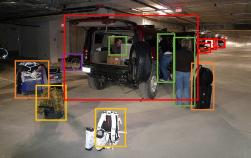

A black SUV is parked in a garage. Two people are loading luggage into the vehicle. There are several bags and suitcases on the floor. The garage is empty except for the car and the people.

In [85]:
from utils import plot_image_base64

plot_image_base64(image_base64_list[0])
Markdown(image_summaries[0])

## Multi-Vector Retriever

Use LangChain's [Multi-Vector Retriever](https://python.langchain.com/v0.2/docs/how_to/multi_vector/#associating-summaries-with-a-document-for-retrieval) to index text, table and image summaries, but retrieve raw images along with raw unsummarized texts and tables.

Add raw docs and doc summaries to [Multi-Vector Retriever](https://python.langchain.com/v0.2/docs/how_to/multi_vector/#associating-summaries-with-a-document-for-retrieval): 

* Store the raw unsummarized texts, tables, and images in the `docstore`.
* Store the summaries of the text, tables, and images in the `vectorstore` for efficient semantic retrieval.

![Multi-Vector Retriever Overview](img/mvr_overview.png)

> **Figure 2**: Image from [LangChain](https://blog.langchain.dev/semi-structured-multi-modal-rag/#multi-vector-retriever). Shows how a Multi-Vector Retriever can be used to associate summaries with a document for retrieval.

In [86]:
# Set to `True` to re-run the step to add documents 
# to the document store and summaries to the vector store.
# Leave it as `False` to re-use existing document
# store and vector store.
RUN_ADD_DOCUMENTS_STEP = False

### Document Store

We will use LangChain's 
[`LocalFileStore`](https://python.langchain.com/v0.2/docs/integrations/stores/file_system/) as the document store for our raw unsummarized texts, tables and images. It basically stores them in your local directory and we can just load them in again when re-running this notebook.

In [87]:
from langchain.storage import LocalFileStore

# Document store for the raw (unsummarized) contents 
# (e.g., texts, tables, images).
document_store = LocalFileStore(
    root_path="data/doc-store"
)

In [88]:
from utils import remove_all_documents_from_store

if RUN_ADD_DOCUMENTS_STEP:
    # Clear all the previous documents from the document store,
    # in preparation for adding the new documents.
    remove_all_documents_from_store(
        document_store
    )

In [89]:
# Number of documents (e.g., raw unsummarized text, tables, images) 
# in the document store.
document_count = sum(1 for _ in document_store.yield_keys())

print(
    f"Document store: {document_count} raw documents"
)

Document store: 26 raw documents


### Vector Store

We will use 
[Chroma](https://python.langchain.com/v0.2/docs/integrations/vectorstores/chroma/) 
vector database as our vector store to index the text, tables and image summaries embeddings. The Chroma database is store on your local file system and can just be loaded in the next time you re-run this notebook.

In [90]:
from langchain_chroma import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings


# Vector store to embed the texts, tables, and images summaries.
vector_store = Chroma(    
    collection_name="multi_modal_rag", 
    embedding_function=GoogleGenerativeAIEmbeddings(
        model="models/text-embedding-004"
    ),
    persist_directory='data/vector-store',
)

In [91]:
if RUN_ADD_DOCUMENTS_STEP:
    # Delete existing collection and recreate a new empty one.
    # Remove the old summaries to make way for the new summaries.
    vector_store.reset_collection()

In [92]:
embedding_count = vector_store._collection.count()

print(
    f"Vector store: {embedding_count} summary embeddings"
)

Vector store: 26 summary embeddings


### Add raw documents and summaries

In [96]:
from typing import Optional

from langchain.storage import LocalFileStore
from langchain_core.vectorstores import VectorStore
from langchain.retrievers.multi_vector import MultiVectorRetriever

from utils import add_documents


def create_multi_vector_retriever(
    vector_store: VectorStore,
    document_store: LocalFileStore,
    text_summaries: Optional[list[str]] = None, 
    raw_texts: Optional[list[str]] = None, 
    table_summaries: Optional[list[str]] = None, 
    raw_tables: Optional[list[str]] = None, 
    image_summaries: Optional[list[str]] = None, 
    raw_images_base64: Optional[list[str]] = None, 
) -> MultiVectorRetriever:
    """
    Create a multi-vector retriever that indexes 
    summaries, but returns raw texts, tables or images.

    Args:
        vector_store: Vector store to store the summaries embeddings.
        document_store: Document store to store the raw 
            unsummarized contents.
        
    Returns:
        A multi-vector retriever.
        
    """
    # Key used for the document ID values.
    id_key = "doc_id"
        
    retriever = MultiVectorRetriever(
        vectorstore=vector_store,
        docstore=document_store,
        id_key=id_key,
    )

    # Add texts, tables, and images.
    # Check that summaries is not `None` before adding.    
    
    if text_summaries:
        add_documents(            
            retriever=retriever, 
            summaries=text_summaries, 
            raw_contents=raw_texts
        )  
        
    if table_summaries:
        add_documents(            
            retriever=retriever, 
            summaries=table_summaries, 
            raw_contents=raw_tables
        )
        
    if image_summaries:
        add_documents(            
            retriever=retriever, 
            summaries=image_summaries, 
            raw_contents=raw_images_base64
        )

    return retriever

In [97]:
if RUN_ADD_DOCUMENTS_STEP:
    # Create multi-vector retriever by adding summaries 
    # to the vector store and raw unsummarized contents to the 
    # document store.
    retriever_multi_vector = create_multi_vector_retriever(
        vector_store=vector_store,
        document_store=document_store,
        text_summaries=text_summaries,
        raw_texts=texts,
        table_summaries=table_summaries,
        raw_tables=tables,
        image_summaries=image_summaries,
        raw_images_base64=image_base64_list,
    )
else:
    # Create multi vector retriever with existing 
    # vector store and document store. 
    # No need to add documents or summaries.
    retriever_multi_vector = create_multi_vector_retriever(
        vector_store=vector_store, 
        document_store=document_store
    )

### Test the retriever

Before we integrate the multi-vector retriever with a LLM, let's try it out on its own first.

Let's see if we can get back images that are relevant to our query.

In [109]:
query = "A bowl of ramen"

retrieved_documents = retriever_multi_vector.invoke(
    input=query,
)

For simplicity, let's just plot the first image that was retrieved. The image is encode in Base64.


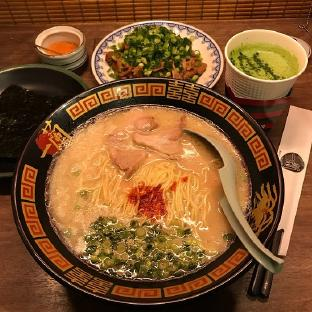

In [110]:
plot_image_base64(
    retrieved_documents[0].decode()
)

Find the summary associated with the image from the vector store:

In [111]:
retrieved_summaries = vector_store.similarity_search(
    query=query, 
    k=1
)

retrieved_summaries[0]

Document(metadata={'doc_id': 'afc8fe74-47ca-4760-98e7-0f7355c3b4f7'}, page_content='A bowl of ramen with pork, noodles, and green onions. There is also a side dish of green onions and a cup of green tea.  The meal is on a wooden table.')

Let's see if it can retrieve tables relevant to our query.

In [107]:
query = "Table comparing performance of LLaVA to other models"

retrieved_documents = retriever_multi_vector.invoke(
    input=query,
)

retrieved_documents[0].decode()

'Conversation Detail description Complex reasoning All OpenFlamingo [5] BLIP-2 [28] LLaVA LLaVA† 19.3 54.6 57.3 58.8 0.5 1.4 1.9 0.6 19.0 29.1 52.5 49.2 0.5 1.2 6.3 0.8 19.1 32.9 81.7 81.4 0.7 0.7 1.8 0.3 19.1 38.1 67.3 66.7 0.4 1.0 2.0 0.3'

Get the summary associated with the table from the vector store:

In [106]:
retrieved_summaries = vector_store.similarity_search(
    query=query, 
    k=1
)

retrieved_summaries[0]

Document(metadata={'doc_id': 'd413ce8e-6489-457e-b3b1-71f8bb867e78'}, page_content='This table compares the performance of four different language models (OpenFlamingo, BLIP-2, LLaVA, and LLaVA†) on four tasks: Conversation Detail description, Complex reasoning, All, and OpenFlamingo. The models are evaluated based on their accuracy scores, with higher scores indicating better performance. LLaVA and LLaVA† consistently outperform the other models across all tasks. \n')

## Retrieval Augmented Generation (RAG)

Let’s put it all together into a chain that takes a question, retrieves relevant documents, constructs a prompt, passes that to a model, and parses the output.

### Multi-Modal Prompt

We will need to build a prompt message that includes a context with zero or more images, tables and texts. This prompt message will then be passed into Gemini 1.5 Flash to synthesize an answer.

> See also: [How to pass multimodal data directly to models](https://python.langchain.com/v0.2/docs/how_to/multimodal_inputs/)

In [112]:
from typing import Any

from langchain_core.messages.base import BaseMessage

from utils import PromptContext


def create_image_text_messages(
    input: dict[str, Any]
) -> list[BaseMessage]:
    """
    Create a list of messages that consists of zero or 
    more images, texts and tables.

    Args:
        input: A dictionary that consists of the following keys:
            - `question`: The user's question or query.
            - `context`: The context dictionary with the keys:
                * `base64_images`: List of images encoded as Base64 string.
                * `texts_or_tables`: List of texts or tables string contents.

    Returns:
        A list of messages that can be passed directly into a chat model.
    """
    question = input["question"]
    context: PromptContext = input["context"]
    
    base64_images = context["base64_images"]
    texts_or_tables = context["texts_or_tables"]    

    # Combine list of texts and tables into one string 
    # to insert into the prompt.
    joined_text_or_tables = "\n".join(texts_or_tables)
    
    messages = []

    # Add image(s) encoded as Base64 string, if any.
    if base64_images:
        for base64_image_str in base64_images:
            image_type_message = {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{base64_image_str}"
                },
            }
            messages.append(image_type_message)
    
    # Add the texts or tables as context.
    text_type_message = {
        "type": "text",
        "text": (
            "You are an assistant for question-answering tasks. "
            "Use the following pieces of retrieved context to answer "
            "the question. The context can include texts, tables "
            "and images. If you don't know the answer, say that you "
            "don't know.\n\n"
            f"Question: {question}\n\n"
            "Texts or tables:\n"
            f"{joined_text_or_tables}"            
        ),
    }
    messages.append(text_type_message)
    
    return [
        HumanMessage(
            content=messages
        )
    ]

### Build the RAG chain

In [113]:
from langchain_core.runnables import (
    RunnableSequence, 
    RunnableLambda, 
    RunnablePassthrough
)

from utils import split_image_text_types


def create_multi_modal_rag_chain(
    retriever: MultiVectorRetriever
) -> RunnableSequence:
    """
    Creates a chain that can perform multi-modal RAG.

    Args:
        retriever: A multi-vector retriever that cwill 
            retrieve the relevant documents.
        
    Returns:
        A runnable chain.
    """
    # Multi-modal LLM
    model = ChatGoogleGenerativeAI(
        temperature=0, 
        model="gemini-1.5-flash", 
        max_tokens=1024
    )

    # RAG pipeline
    chain = (
        {
            "context": (
                retriever 
                | RunnableLambda(split_image_text_types)
            ),
            "question": RunnablePassthrough()
        }
        | RunnableLambda(create_image_text_messages)        
        | model
        | StrOutputParser()
    )

    return chain    

In [114]:
# Create RAG chain
multimodal_rag_chain = create_multi_modal_rag_chain(
    retriever_multi_vector
)

### Test out the RAG chain

Finally, let's run our multi-modal RAG chain and test it out with some queries.

First, let's try asking it about an image in the PDF document:

In [136]:
query = (
    "What is unusual about the image of a man "
    "ironing clothes on the back of a yellow van?"
)
response = multimodal_rag_chain.invoke(
    input=query
)
Markdown("> " + response)

> The unusual aspect of the image is a man ironing clothes on the back of a minivan or van. This is not a typical place to perform this activity, as one would usually iron clothes in a more stationary and safe location, such as a home, using a regular ironing board. The scene depicted in the image is peculiar as it involves a makeshift ironing setup on a vehicle, which can be both unsafe and unconventional. Additionally, it is not clear how the man is able to maintain balance and stability while ironing clothes in such an unstable environment.

Let's take a look at the image that Gemini 1.5 Flash was describing to us:


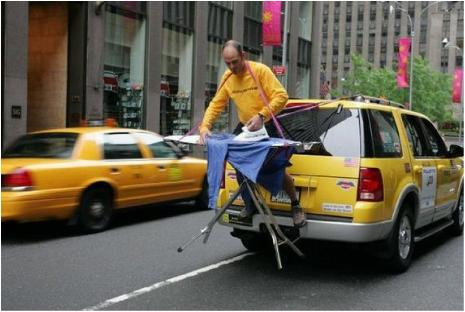

In [137]:
retrieved_raw_docs = retriever_multi_vector.invoke(
    input=query    
)

plot_image_base64(
    retrieved_raw_docs[0].decode()
)

The summary of the image that was used to retrieve the raw image:

In [138]:
retrieved_summary_docs = vector_store.similarity_search(
    query=query
)

retrieved_summary_docs[0]

Document(metadata={'doc_id': '793b12f8-1f74-452e-85b2-bc17a9245e33'}, page_content='A man in a yellow shirt is ironing clothes on a yellow SUV taxi in the middle of the street, while a yellow taxi drives by in the background.')

Next, let's ask the chat model about a table in the PDF document:

In [139]:
query = (
    "How did LLaVA perform compared to "
    "BLIP-2 and OpenFlamingo?"
)
response = multimodal_rag_chain.invoke(
    input=query
)
Markdown("> " + response)

> LLaVA outperformed BLIP-2 and OpenFlamingo on the LLaVA-Bench (In-the-Wild) benchmark. It achieved a score that was 29% higher than BLIP-2 and 48% higher than OpenFlamingo. 


The table that was used to provide the context to Gemini 1.5 Flash to synthesize an answer:

In [140]:
retrieved_raw_docs = retriever_multi_vector.invoke(
    input=query    
)

retrieved_raw_docs[1].decode()

'Conversation Detail description Complex reasoning All OpenFlamingo [5] BLIP-2 [28] LLaVA LLaVA† 19.3 54.6 57.3 58.8 0.5 1.4 1.9 0.6 19.0 29.1 52.5 49.2 0.5 1.2 6.3 0.8 19.1 32.9 81.7 81.4 0.7 0.7 1.8 0.3 19.1 38.1 67.3 66.7 0.4 1.0 2.0 0.3'

The summary of the table that was used to retrieve the actual table contents:

In [141]:
retrieved_summary_docs = vector_store.similarity_search(
    query=query
)

retrieved_summary_docs[1]

Document(metadata={'doc_id': 'd413ce8e-6489-457e-b3b1-71f8bb867e78'}, page_content='This table compares the performance of four different language models (OpenFlamingo, BLIP-2, LLaVA, and LLaVA†) on four tasks: Conversation Detail description, Complex reasoning, All, and OpenFlamingo. The models are evaluated based on their accuracy scores, with higher scores indicating better performance. LLaVA and LLaVA† consistently outperform the other models across all tasks. \n')

In [142]:
query = (
    "What was the conclusion of the LLaVA paper?"
)
response = multimodal_rag_chain.invoke(
    input=query
)
Markdown("> " + response)

> The LLaVA paper concluded that visual instruction tuning is effective for improving multimodal models' ability to follow instructions and complete visual tasks. LLaVA, a multimodal model trained on language-image instruction-following data, achieved state-of-the-art accuracy on ScienceQA and demonstrated excellent visual chat capabilities. The paper also introduced two benchmarks for evaluating multimodal instruction-following capabilities, highlighting LLaVA's impressive performance compared to other models. The authors acknowledged that LLaVA is still under development and has limitations, but they hope it will serve as a solid baseline for future research on building more capable multimodal models. 


## Conclusion

In this notebook, we have seen how you can perform RAG over texts, tables and images using a multi-modal model such as Gemini 1.5 Flash. We have also seen how to use LangChain's MultiVectorRetriever together with image summaries to improve RAG over images.

### Further readings

See also the following LangChain blog posts and cookbooks for more info on multi-modal RAG:
* [Multi-Vector Retriever for RAG on tables, text, and images](https://blog.langchain.dev/semi-structured-multi-modal-rag/)
* [Multi-modal RAG on slide decks](https://blog.langchain.dev/multi-modal-rag-template/)
* [LangChain Cookbooks](https://github.com/langchain-ai/langchain/blob/master/cookbook/README.md)
